In [ ]:
import pandas as pd
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
import geopandas as gpd # To create GeodataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

In [ ]:
original_df = pd.read_csv('/work/trips.csv')
header_df = pd.read_csv('/work/TripBulkReportTripsHeaders.csv')
trips_df = pd.concat([original_df,header_df])

In [ ]:
trips_df.head()

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MovementType,OriginCbg,DestCbg,StartTimezone,EndTimezone,WaypointFreqSec,StartQk,EndQk,Unnamed: 31,Unnamed: 32
0,a939d5d8c9b52b5265161bfa93054f0a,0006da8402c807c4be339cab03f9d498,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T20:19:31.000Z,3,2022-05-11T20:22:52.000Z,3,30.18252,-96.93443,...,1,NaN,NaN,America/Chicago,America/Chicago,NaN,2.313010e+16,2.313010e+16,NaN,NaN
1,88180c2feb14c8520f169e4bda526313,009ef4b15eadd773468cd2bfdff6eb54,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T21:07:54.000Z,6,2022-05-14T21:58:03.000Z,6,38.27969,-104.52873,...,1,NaN,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,"{\method\"":\""fused\""","\""aid_type\"":\""AAID\""}"""
2,a4d0936eb3b45ff1a5af8885939fbcd5,011dbfd3e177545535328ba48377522f,74071a673307ca7459bcf75fbd024e09,0,2022-05-13T21:40:44.000Z,5,2022-05-13T21:48:42.000Z,5,38.75461,-104.78828,...,1,NaN,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,"{\method\"":\""fused\""","\""aid_type\"":\""AAID\""}"""
3,a04c70dd5a17f8f54b7a5576951da0c5,014b33b72b76a3ba8cbb621009408974,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T23:37:31.000Z,3,2022-05-11T23:47:49.000Z,3,38.67639,-104.70588,...,1,NaN,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,NaN,NaN
4,509bba65db0e6495bb35e615f823350c,014ed4fc9ea19b744e0eb3a0b1d72bb1,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T00:14:40.000Z,3,2022-05-12T00:37:38.000Z,3,38.55622,-104.64958,...,1,NaN,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,"{\method\"":\""gps\""","\""aid_type\"":\""IDFA\""}"""


#  Data Cleaning

### 1. Make sure there are no duplicate rows

In [ ]:
number_of_dup = len(trips_df[trips_df.duplicated(subset=list(trips_df.columns).remove('TripId')) == True])

print('Number of rows in original data:', len(trips_df))
print('Number of duplicated rows : ',number_of_dup)

Number of rows in original data: 136880
Number of duplicated rows :  0


### 2. Create geometry column

In [ ]:
# creating a geometry column 
trips_df['Startlocation'] = list(zip(trips_df.StartLocLat, trips_df.StartLocLon))
trips_df['Startlocation'] = trips_df['Startlocation'].apply(Point)

trips_df['Endlocation'] = list(zip(trips_df.EndLocLat, trips_df.EndLocLon))
trips_df['Endlocation'] = trips_df['Endlocation'].apply(Point)


# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(trips_df, crs=crs)


### 3. Deal with Datetime

In [ ]:
gdf['MST_start_datetime'] = pd.to_datetime(gdf['StartDate']).apply(lambda x:x.astimezone('MST'))
gdf['MST_end_datetime'] = pd.to_datetime(gdf['EndDate']).apply(lambda x:x.astimezone('MST'))

gdf['MST_start_date'] = gdf['MST_start_datetime'].apply(lambda x:x.date())
gdf['MST_start_time'] = gdf['MST_start_datetime'].apply(lambda x:x.time())

gdf['MST_end_date'] = gdf['MST_end_datetime'].apply(lambda x:x.date())
gdf['MST_end_time'] = gdf['MST_end_datetime'].apply(lambda x:x.time())

### 4.Exclude data whose ProviderType == Fleet

[Text(0, 0, '127805'), Text(0, 0, '9075')]

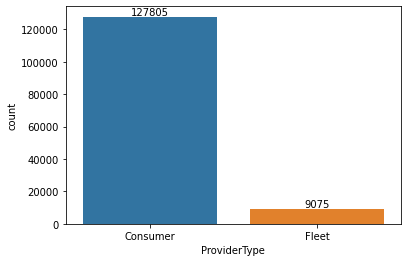

In [ ]:
provider_type = sns.countplot(trips_df['ProviderType'])
provider_type.set_xticklabels(['Consumer','Fleet'])
provider_type.bar_label(provider_type.containers[0])

In [ ]:
# exclude data whose ProviderType == Fleet
gdf = gdf[gdf['ProviderType']==1] 
gdf.head()

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,Unnamed: 31,Unnamed: 32,Startlocation,Endlocation,MST_start_datetime,MST_end_datetime,MST_start_date,MST_start_time,MST_end_date,MST_end_time
0,a939d5d8c9b52b5265161bfa93054f0a,0006da8402c807c4be339cab03f9d498,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T20:19:31.000Z,3,2022-05-11T20:22:52.000Z,3,30.18252,-96.93443,...,NaN,NaN,POINT (30.18252 -96.93443),POINT (30.18015 -96.91383),2022-05-11 13:19:31-07:00,2022-05-11 13:22:52-07:00,2022-05-11,13:19:31,2022-05-11,13:22:52
1,88180c2feb14c8520f169e4bda526313,009ef4b15eadd773468cd2bfdff6eb54,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T21:07:54.000Z,6,2022-05-14T21:58:03.000Z,6,38.27969,-104.52873,...,"{\method\"":\""fused\""","\""aid_type\"":\""AAID\""}""",POINT (38.27969 -104.52873),POINT (38.34004 -104.67292),2022-05-14 14:07:54-07:00,2022-05-14 14:58:03-07:00,2022-05-14,14:07:54,2022-05-14,14:58:03
2,a4d0936eb3b45ff1a5af8885939fbcd5,011dbfd3e177545535328ba48377522f,74071a673307ca7459bcf75fbd024e09,0,2022-05-13T21:40:44.000Z,5,2022-05-13T21:48:42.000Z,5,38.75461,-104.78828,...,"{\method\"":\""fused\""","\""aid_type\"":\""AAID\""}""",POINT (38.75461 -104.78828),POINT (38.74819 -104.78828),2022-05-13 14:40:44-07:00,2022-05-13 14:48:42-07:00,2022-05-13,14:40:44,2022-05-13,14:48:42
3,a04c70dd5a17f8f54b7a5576951da0c5,014b33b72b76a3ba8cbb621009408974,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T23:37:31.000Z,3,2022-05-11T23:47:49.000Z,3,38.67639,-104.70588,...,NaN,NaN,POINT (38.67639 -104.70588),POINT (38.73319 -104.77867),2022-05-11 16:37:31-07:00,2022-05-11 16:47:49-07:00,2022-05-11,16:37:31,2022-05-11,16:47:49
4,509bba65db0e6495bb35e615f823350c,014ed4fc9ea19b744e0eb3a0b1d72bb1,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T00:14:40.000Z,3,2022-05-12T00:37:38.000Z,3,38.55622,-104.64958,...,"{\method\"":\""gps\""","\""aid_type\"":\""IDFA\""}""",POINT (38.55622 -104.64958),POINT (38.2193 -104.6537),2022-05-11 17:14:40-07:00,2022-05-11 17:37:38-07:00,2022-05-11,17:14:40,2022-05-11,17:37:38


# EDA 

### 1. Number of Device

In [ ]:
device_number = len(gdf['DeviceId'].unique())
print('These {} trips are from {} unique devices.'.format(len(trips_df),device_number))

These 136880 trips are from 68188 unique devices.


### 2. Walk vs. Vehicle

[Text(0, 0, '7812'), Text(0, 0, '117149'), Text(0, 0, '2844')]

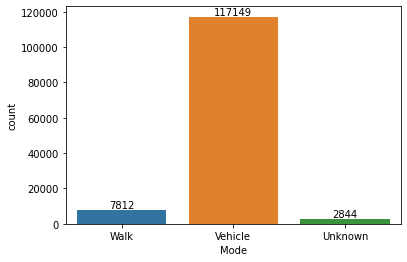

In [ ]:
count_plot = sns.countplot(gdf['Mode'])
count_plot.set_xticklabels(['Walk','Vehicle','Unknown']) 
count_plot.bar_label(count_plot.containers[0])

### 3. Vehicle type

[Text(0, 0, '51745'), Text(0, 0, '76060')]

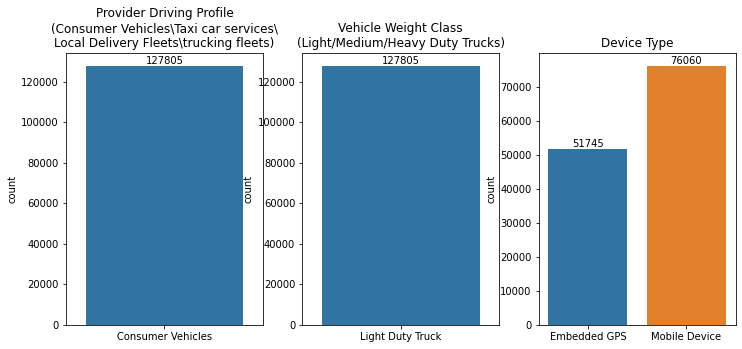

In [ ]:
fig,[ax1,ax2,ax3] = plt.subplots(nrows=1, ncols=3,figsize=(12,5))
sns.countplot(gdf['ProviderDrivingProfile'],ax=ax1)
title1='Provider Driving Profile' + '\n'+'(Consumer Vehicles\\Taxi car services\\'+'\n'+ 'Local Delivery Fleets\\trucking fleets)'
ax1.set_title(title1)
ax1.set_xticklabels(['Consumer Vehicles']) 
ax1.set(xlabel=None)
ax1.bar_label(ax1.containers[0])

sns.countplot(gdf['VehicleWeightClass'],ax=ax2)
title2 = 'Vehicle Weight Class' + '\n'+ '(Light/Medium/Heavy Duty Trucks)'
ax2.set_title(title2)
ax2.set_xticklabels(['Light Duty Truck'])
ax2.set(xlabel=None)
ax2.bar_label(ax2.containers[0])

sns.countplot(gdf['ProbeSourceType'],ax=ax3)
ax3.set_title('Device Type')
ax3.set_xticklabels(['Embedded GPS','Mobile Device'])
ax3.set(xlabel=None)
ax3.bar_label(ax3.containers[0])

### 4.Trips per Device

In [ ]:
gdf.groupby('DeviceId').count()['TripId'].sort_values(ascending=False)

DeviceId
70e68ce6b66dd2052c188f2bd8ad0563    91
c6d52211ec83fb63badb38f323b9544e    87
b4ff8360a3e7ac8fa763580f3202936f    84
7ebcf69bfbf7b47abab7ef0db2a72f08    73
0f38377b674a05d3e686a692b1ad0571    73
                                    ..
5c2fcec0520b960ecdeb168f1a8d5a6b     1
5c31552bf5a1b828a6ee2ed83befe84d     1
5c3456a48b6bcfccc423cd81d95b66fc     1
5c34fce528d5773151acc2f75af81476     1
fffea5a18f1a308cee147a3e9c726700     1
Name: TripId, Length: 68188, dtype: int64

##### On average, during the month of May each device visits Fort Carson 1.76 times. 

In [ ]:
# Calculate mean number of trips per deviceId
mean_frequency = gdf.groupby(by = ["Mode","DeviceId"]).count()['TripId'].mean()
print('During the month of May, on average each device frequents Fort Carson ' + str(mean_frequency) + ' times.')


During the month of May, on average each person frequents Fort Carson 1.7569871186813488 times.


In [ ]:
top_100_device_frequency = gdf['DeviceId'].value_counts().nlargest(1000)

print('Top 1000 most frequent deviceIds in May, 2022:\n' ,top_100_device_frequency)

Top 1000 most frequent deviceIds in May, 2022:
 70e68ce6b66dd2052c188f2bd8ad0563    91
c6d52211ec83fb63badb38f323b9544e    87
b4ff8360a3e7ac8fa763580f3202936f    84
7ebcf69bfbf7b47abab7ef0db2a72f08    73
0f38377b674a05d3e686a692b1ad0571    73
                                    ..
c06d8390b8541734835221d3980d89e1    16
f5388ef71fe7781042079583b259ee4b    16
c8c0671e805d42ea2e93c416d1cfa273    16
e7a6a3cdae71e68654f415f5630e9c76    16
ef62dabbb4f2595d04add69385da4e34    16
Name: DeviceId, Length: 1000, dtype: int64


70e68ce6b66dd2052c188f2bd8ad0563    91
c6d52211ec83fb63badb38f323b9544e    87
b4ff8360a3e7ac8fa763580f3202936f    84
7ebcf69bfbf7b47abab7ef0db2a72f08    73
0f38377b674a05d3e686a692b1ad0571    73
fdb8335a86289cc02c878d534acc64d6    72
4463db876cfb9492daaac5b440b07e8c    69
3de0769d66ec0c1d5af1c6932a7cb11b    69
12442b4a8ce203b9691b4c75ec448568    67
7f9a222ec5dabd2c4e3a5ad18015a8e3    66
Name: DeviceId, dtype: int64

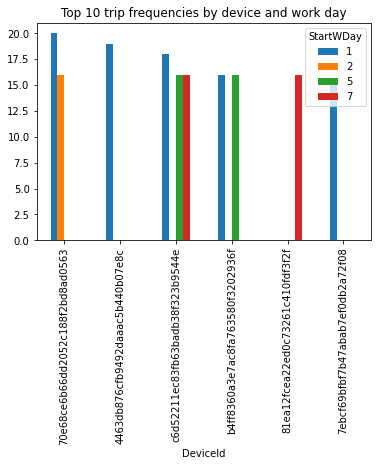

In [ ]:
top_10_device_frequency_by_day = gdf.groupby(["StartWDay",'DeviceId']).count()['TripId'].nlargest(10).unstack(0).plot.bar(title = 'Top 10 trip frequencies by device and work day')
top_10_device_frequency_by_day = gdf['DeviceId'].value_counts().nlargest(10)
top_10_device_frequency_by_day


Mode  DeviceId                          MST_start_datetime
1     27f1ed72366fed2785ed61872bebd591  4                     12
      b329d24cce75151cf90c59d3496a6376  8                     12
      08e349a7568e0b3438b6389f6b09be2b  10                    11
      a1b6f3ef1acd4d92a0e5d842d18cfcea  11                    11
      a2b605e269966e8045debd0c07fcf339  7                     11
      fc300205a2b6928df2c24354c0215426  5                     11
      fdb8335a86289cc02c878d534acc64d6  11                    11
      06b1fe61ea89c343ac60b3e582a1ca1c  5                     10
      08e349a7568e0b3438b6389f6b09be2b  8                     10
      0b4b497a3d93421ef76916d00fd3ef3c  8                     10
Name: TripId, dtype: int64


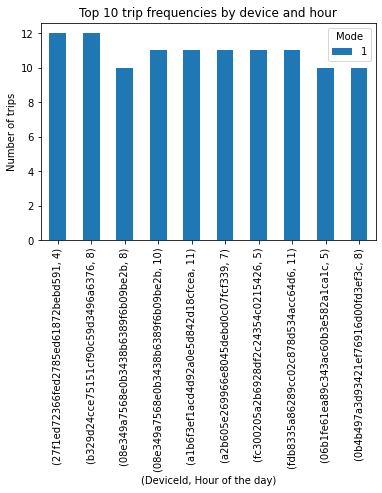

In [ ]:
# Plot top 10 trip frequency based on hour and deviceId
gdf.groupby(['Mode','DeviceId',gdf['MST_start_datetime'].map(lambda x : x.hour)]).count()['TripId'].nlargest(10).unstack(0).plot.bar(title = 'Top 10 trip frequencies by device and hour', xlabel='(DeviceId, Hour of the day)', ylabel = 'Number of trips')
device_by_hour = gdf.groupby(['Mode','DeviceId',gdf['MST_start_datetime'].map(lambda x : x.hour)]).count()['TripId'].nlargest(10)
print(device_by_hour)

### 5.Trip Length

In [ ]:
trip_length = gdf['MST_end_datetime']-gdf['MST_start_datetime']

days, seconds = trip_length.apply(lambda x:x.days), trip_length.apply(lambda x:x.seconds)
hours = days * 24 + seconds // 3600

trip_length_minutes = (gdf['MST_end_datetime']-gdf['MST_start_datetime']).apply(lambda x:x.seconds//60)

Text(0.5, 0, 'trip length (minutes)')

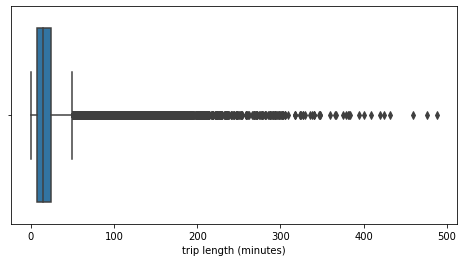

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(trip_length_minutes)
plt.xlabel('trip length (minutes)')

### 6. Number of trips within vs. to vs. from Fort Carson

[Text(0, 0, '38637'), Text(0, 0, '50647'), Text(0, 0, '38521')]

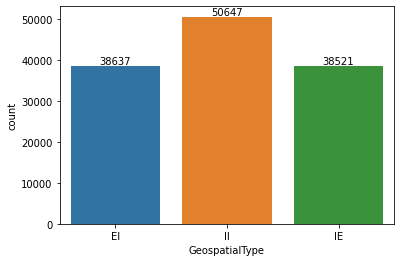

In [ ]:
ax = sns.countplot(gdf['GeospatialType'])
ax.bar_label(ax.containers[0])

### 7.How often did they visit the facility?

##### To analyze the pattern of consumer visits to the facility, we have constructed bar charts of trips taken and grouped by day of the week for each trip type. 

##### From the chart, we can see that vehicle is the most common mode of transportation and most consumers visit the facility on Monday, Tuesday, Wednesday, and Friday

### Bar chart of trips available by day (for each trip type)

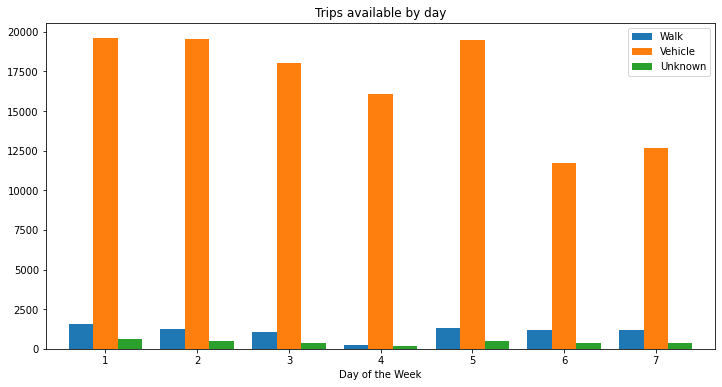

In [ ]:
# Plotting bar chart for trips available by day (for each trip type)
index = ['Walk', 'Vehicle', 'Unknown']
ticks = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
trip_type = gdf.groupby(by = ["Mode","StartWDay"]).count()['TripId'].unstack(0).plot.bar(figsize=(12, 6), width=0.8, linewidth=0.2, title='Trips available by day', rot=0, xlabel="Day of the Week") 
trip_type.legend(index)

##### Next, for each trip type we look at trips taken by hour of the day and found that between 5:00 am and 5:00 pm MST. 

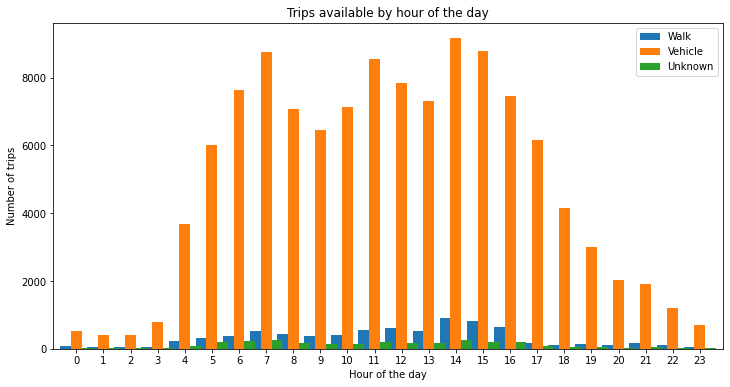

In [ ]:
# Plot bar chart of trips available by hour of the day (for each trip type)
trip_by_hour = gdf.groupby(by=['Mode',gdf['MST_start_datetime'].map(lambda x : x.hour)]).count()['TripId'].unstack(0).plot.bar(width = 1.2,title='Trips available by hour of the day', xlabel='Hour of the day',
ylabel='Number of trips',rot = 0, figsize=(12, 6))
trip_by_hour.legend(index)

<AxesSubplot:xlabel='StartWDay', ylabel='count'>

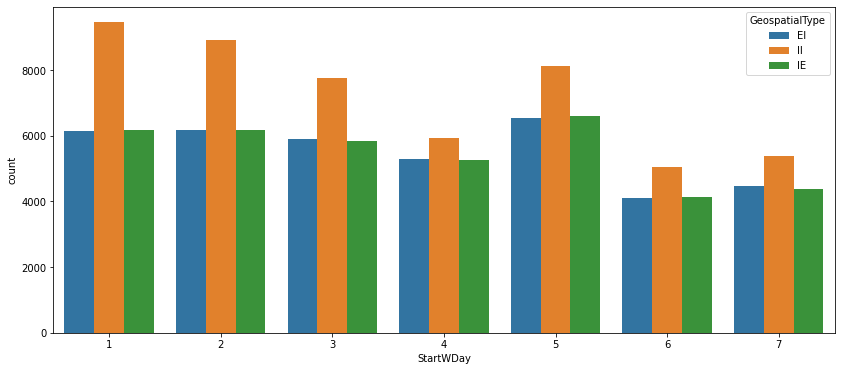

In [ ]:
plt.figure(figsize=(14,6))
sns.countplot(gdf['StartWDay'],hue=gdf['GeospatialType'])


### 8.How long did they stay in the facility?

<AxesSubplot:xlabel='length_minutes'>

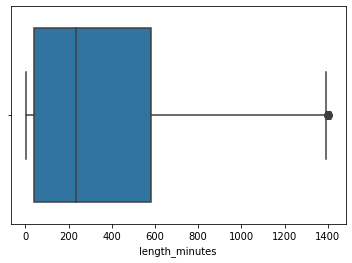

In [ ]:
stay_length_df = pd.read_csv('/work/trips_duration.csv')
sns.boxplot(stay_length_df['length_minutes'])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9863cd21-6747-4678-bbdd-813e8a94296e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>